# Earth at Night from Day: Predicting Nighttime Radiance from Daytime Satellite Imagery
Isaiah Lyons-Galante  
University of Colorado Boulder



# Introduction

The imprint of human activity on Earth has become unmistakable, offering a unique vantage point for population studies through the lens of space. Access to global high-resolution datasets, such as Landsat(1), has been made possible for the public through platforms like Google Earth Engine (3). These datasets open a window to observe and analyze human settlements, providing invaluable insights into the dynamics of our changing world. The image below is from Google Earth, showing the twin cities of Brazzaville and Kishasa on the banks of the Congo River. One can clearly see the densely package settlements on the banks, along with the unpopulated islands in the river.

![brazzaville](./figs/brazzaville.png)

During the night, human presence becomes even more apparent as settlements cast a faint glow into space. This nocturnal illumination is captured by the VIIRS instrument aboard the Suomi National Polar-orbiting Partnership (NPP) satellite. Despite its significance, the relatively weak signals limit the resolution to about 500 meters squared. This limitation poses a challenge to extracting fine-grained information about the distribution and characteristics of human settlements. The image below is of the same area as the one above, but at night. The resolution is significantly lower, with the pixels clearly visible, while the island in the river is completely dark.

![brazzaville night](./figs/brazzavilleatnight.png)

Compelling research underscores the correlation between night lights and mean household wealth, as measured by ground surveys. This correlation establishes night lights as a proxy for gauging livelihoods, making them a valuable tool for socio-economic analyses. This becomes particularly crucial in regions like Sub-Saharan Africa, where traditional population surveys are sparse. The scarcity of on-the-ground data highlights the potential of night lights as a surrogate measure for understanding the economic landscapes of communities. The graph below shows the relationship between night lights and mean household wealth in Sub-Saharan Africa. The data is from the Demographic and Health Surveys (DHS) Program, which conducts household surveys in developing countries. The graph shows a clear correlation between night lights and mean household wealth.

![night lights and wealth](./figs/wealthcorrelations.jpg)

The demand for higher-resolution night lights becomes evident when considering the need for detailed impact assessments. Such assessments can unravel the intricate ways in which individual communities are affected by economic development programs or global events. As technology advances, the quest for sharper and more detailed night light data gains significance, promising to enhance our understanding of human settlements and socio-economic patterns on a global scale. One example of this comes from a paper in Nature just last year that use wealth maps to assess the economic impact of access to electricity. High resolution nightlights would open up even finer grained analysis.

![wealth map](./figs/WealthMap.png)

Embarking on this exploration of human settlements and socio-economic patterns, I employ cutting-edge methodologies to surmount the resolution challenges posed by existing night light data. Leveraging the power of machine learning, my approach involves training a model to predict night lights from high-resolution daytime imagery. By undertaking this innovative process, I aim to transcend the limitations of the existing data and generate high-resolution nighttime imagery. This fusion of technological advancements with geospatial analysis not only promises to enrich our understanding of human settlements but also sets the stage for a more nuanced examination of the impact of economic development programs and global events on individual communities. This notebook will serve as a guide for the entire process, from method design to model training and evaluation, and finally, the results and conclusions. The code is available on [GitHub](https://github.com/isaiahlg/csci5922/blob/main/proj/unet_regression_virrs.ipynb).



# Methods
Because I are trying to predict one image from another, I can leverage a Fully Convolutional Network (6) with no dense layers. This allow us to use input imagery of any resolution. The U-Net (7) architecture, named for the shape of the diagram, is the most popular FCN and is well suited to our task. The output layer is modified to perform regression instead of classification so that I get a continuous radiance value instead of segment class. Below is a diagram of U-Net from the original paper -- notice the distintive U shape.

![unet](./figs/unet.png)

With the model in place, I then need to define our training data. In this project, four different training datasets were tested: both large training regions with 1000 image patch samples from each, as well as small regions with 100 image patch samples from each. Each of these were pulled from the United States and the African continent.  For each, there were 8 unique training regions, and 2 evaluation regions. For both areas, the polygons were centered around urban areas, as these have the greatest range of values in nighttime radiance. For consistency, the evaluation areas were also urban areas. Because the target is to predict nightlights in under-surveyed areas, the evaluation sites were Abuja, Nigeria, and Nairobi, Kenya. On the left, I have the large image patches from North America, and on the right from the African. Training patches are in yellow, and evaluation regions are in blue. The aim of having different continents as inputs was to test how transferrable the results are. Do well-lit areas in the US look like well-lit areas in Africa? 

American Cities             |  African Cities
:-------------------------:|:-------------------------:
![](./figs/usatrain.png)  |  ![](./figs/africatrain.png)


For daytime imagery inputs, I pulled 9 bands from Landsat, 7 optical bands and 2 thermal bands. I created a cloud-masked image composite to create high-quality, cloud free input. For nightlight output, I also create a median composite of the average radiance band from stray-light corrected nightlights.8 The aim is that by pairing each daytime image patch of 256 x 256 with the corresponding nighttime image patch, I can predict nighttime image patches of 128x128 when the original resolution was about 16x16. This is almost 60X improvement in resolution.  Below on the left, I have a set of example input images from Landsat in false-color. The level of detail is significant compared with the coarse nightlight image patches on the right. 

Sample Training Inputs            |  Sample Training Labels
:-------------------------:|:-------------------------:
![](./figs/trainpatches.png)  |  ![](./figs/labelpatches.png)

The other parameters that were experimented with were the number of epochs and the optimizer algorithm. For epochs, values between 1 and 50 were tried for most models. For the optimizer, a single experiment was run with one of the top performing models to see how it would compare. The imagery was compiled in Google Earth Engine via their Python API (9), exported to a Linux computer with a 48GB GPU. The model was built with tensorflow (10), code is available on GitHub (11).


# Code for Implementing the Model

Below are the chunks of code to gather the data. To run it yourself, copy and paste the .env.example file to .env and fill in your own file paths and Google Earth Engine credentials. You need an account on Google Cloud Platform with Storage Buckets and access to the Google Earth Engine API to run this, but it can be adapted to export to Google Drive instead before copying it locally.

## Configure the Environment

In [1]:
# Read in the .env file
from dotenv import dotenv_values, load_dotenv

# load env variables
config = dotenv_values(".env")
load_dotenv()

# set env variables
GCS_PROJECT = config['GCS_PROJECT']
BUCKET = config['BUCKET']
HOME_PATH = config['HOME_PATH']
LOCAL_PATH = config['LOCAL_PATH']
DATA_PATH = config['DATA_PATH']
FOLDER = config['FOLDER']
GCLOUD_PATH = config['GCLOUD_PATH']
DEVICE = config['DEVICE']
CUDA_VISIBLE_DEVICES = config['CUDA_VISIBLE_DEVICES']
GPU_MEMORY_LIMIT = int(config['GPU_MEMORY_LIMIT'])
GPU_MEMORY_CAPACITY = int(config['GPU_MEMORY_CAPACITY'])

print(config)


OrderedDict([('GCS_PROJECT', 'masters-thesis-ilg'), ('BUCKET', 'viirs-africa-huge/'), ('HOME_PATH', '/Users/isaiah/'), ('LOCAL_PATH', '/ADrive/data/'), ('DATA_PATH', '/data/'), ('FOLDER', 'unet-viirs/'), ('GCLOUD_PATH', '/Users/isaiah/google-cloud-sdk/bin/gcloud'), ('DEVICE', 'mps'), ('CUDA_VISIBLE_DEVICES', '0'), ('GPU_MEMORY_LIMIT', '16000'), ('GPU_MEMORY_CAPACITY', '24000')])


## Import Key Libraries and Authenticate to Google Earth Engine

We use Earth Engine to fetch, process, and display our imagery. We use tensorflow to build and train our model. Finally, we use folium to create interactive maps to display our results.

In [30]:
# Import, authenticate and initialize the Earth Engine library.
import ee
ee.Authenticate()
ee.Initialize()

# Tensorflow setup.
# import tensorflow as tf
# print(tf.__version__)

# supress warnings
import warnings
warnings.filterwarnings('ignore')

import geemap

## Set other Global Variables

In [3]:
# variables for image names
TRAINING_BASE = 'training_patches'
EVAL_BASE = 'eval_patches'

# Specify inputs (Landsat bands) to the model and the response variable.
opticalBands = ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7']
thermalBands = ['ST_B10']
BANDS = opticalBands + thermalBands
RESPONSE = 'avg_rad' ##### 
FEATURES = BANDS + [RESPONSE]

# Specify the size and shape of patches expected by the model.
# KERNEL_SIZE = 256
# KERNEL_SHAPE = [KERNEL_SIZE, KERNEL_SIZE]
# COLUMNS = [
#   tf.io.FixedLenFeature(shape=KERNEL_SHAPE, dtype=tf.float32) for k in FEATURES
# ]
# FEATURES_DICT = dict(zip(FEATURES, COLUMNS))

# Sizes of the training and evaluation datasets.
# TRAIN_SIZE = 4800
# EVAL_SIZE = 200

# # Specify model training parameters.
# BATCH_SIZE = 48 ## TODO change to power of 2 (32)
# EPOCHS = 1
# BUFFER_SIZE = 2000
# OPTIMIZER = 'SGD' ## TODO: change to Adam
# LOSS = 'MeanSquaredError'
# METRICS = ['RootMeanSquaredError']

# Data Preparation

Gather and setup the imagery to use for inputs (predictors).  This is a three-year, cloud-free, Landsat 8 composite.  Display it in the notebook for a sanity check.

In [18]:
l8 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filterDate('2020-01-01', '2020-12-31')

# Apply scaling factors.
def apply_scale_factors(image):
  optical_bands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
  thermal_bands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
  return image.addBands(optical_bands, None, True).addBands(
      thermal_bands, None, True
)
l8 = l8.map(apply_scale_factors)

# Cloud mask function using QA_PIXEL band
def mask_clouds(image):
    qa = image.select('QA_PIXEL')
    cloud_mask = qa.bitwiseAnd(1 << 3).eq(0)  # Keep only non-cloudy pixels
    return image.updateMask(cloud_mask)
l8 = l8.map(mask_clouds).median()


visualization = {
    'bands': ['SR_B4', 'SR_B3', 'SR_B2'],
    'min': 0.0,
    'max': 0.3,
}

m = geemap.Map()
m.set_center(-74, 40.7, 10)
m.add_layer(l8, visualization, 'True Color (432)')
m

Map(center=[40.7, -74], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_…

Prepare the response (what we want to predict).  This is nighttime brightness (in nanoWatts/sr/cm^2) from the VIIRS dataset.  Display to check.

In [27]:
viirs = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG") \
    .select('avg_rad') \
    .filterDate('2020-01-01', '2020-12-31') \
    .median()

m = geemap.Map()
m.set_center(-74, 40.7, 10)
m.add_layer(viirs, {'min': 0.0, 'max': 90.0}, 'VIIRS DNB')
m

Map(center=[40.7, -74], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_…

## Bring in a High Resolution Image for Comparison
This is a 10-meter resolution nighttime image of New York City from 2020.

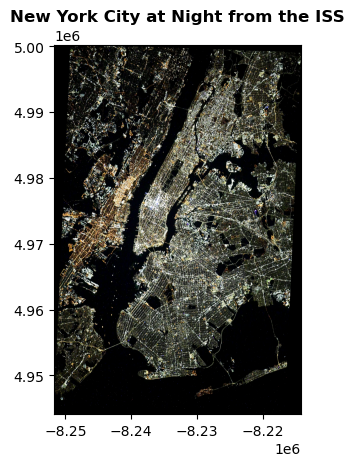

CRS.from_epsg(3857)

In [49]:
import rasterio
import rasterio.plot

nyc_image_path = '/Users/isaiah/data/unet-viirs/iss/nyc/ISS064E40613_1.tif'
nyc = rasterio.open(nyc_image_path)
rasterio.plot.show(nyc, title = "New York City at Night from the ISS")
nyc.crs

In [48]:
viirs = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG") \
    .select('avg_rad') \
    .filterDate('2020-01-01', '2020-12-31') \
    .median()

m = geemap.Map(height='1000px')
m.set_center(-74, 40.7, 10)
m.add_layer(viirs, {'min': 0.0, 'max': 100.0}, 'VIIRS DNB')
# geemap.Map.add_raster documentation
# https://github.com/gee-community/geemap/blob/6f17eba218ffa40a89a9803cb83c3d47ff6b032b/geemap/geemap.py#L2468
# Args:
#             source (str): The path to the GeoTIFF file or the URL of the Cloud Optimized GeoTIFF.
#             indexes (int, optional): The band(s) to use. Band indexing starts at 1. Defaults to None.
#             colormap (str, optional): The name of the colormap from `matplotlib` to use when plotting a single band. See https://matplotlib.org/stable/gallery/color/colormap_reference.html. Default is greyscale.
#             vmin (float, optional): The minimum value to use when colormapping the palette when plotting a single band. Defaults to None.
#             vmax (float, optional): The maximum value to use when colormapping the palette when plotting a single band. Defaults to None.
#             nodata (float, optional): The value from the band to use to interpret as not valid data. Defaults to None.
#             attribution (str, optional): Attribution for the source raster. This defaults to a message about it being a local file.. Defaults to None.
#             layer_name (str, optional): The layer name to use. Defaults to 'Raster'.
#             zoom_to_layer (bool, optional): Whether to zoom to the extent of the layer. Defaults to True.
#             visible (bool, optional): Whether the layer is visible. Defaults to True.
#             array_args (dict, optional): Additional arguments to pass to `array_to_memory_file` when reading the raster. Defaults to {}.
m.add_raster(nyc_image_path, colormap='gray', layer='NYC', opacity=0.4)
m

Map(center=[40.7, -74], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(c…

## Create Training Data

Stack the 2D images (Landsat composite and VIIRS DNB image) to create a single image from which samples can be taken.  Convert the image into an array image in which each pixel stores 256x256 patches of pixels for each band.  This is a key step that bears emphasis: to export training patches, convert a multi-band image to [an array image](https://developers.google.com/earth-engine/arrays_array_images#array-images) using [`neighborhoodToArray()`](https://developers.google.com/earth-engine/api_docs#eeimageneighborhoodtoarray), then sample the image at points.

In [ ]:
featureStack = ee.Image.cat([
  l8.select(BANDS),
  viirs.select(RESPONSE)
]).float()

list = ee.List.repeat(1, KERNEL_SIZE)
lists = ee.List.repeat(list, KERNEL_SIZE)
kernel = ee.Kernel.fixed(KERNEL_SIZE, KERNEL_SIZE, lists)

arrays = featureStack.neighborhoodToArray(kernel)

# Define Training and Evaluation Areas
Use some pre-made geometries to sample the stack in strategic locations.  Specifically, these are hand-made polygons in which to take the 256x256 samples.  Display the sampling polygons on a map, red for training polygons, blue for evaluation. You'll need to create these polygons ahead of time yourself and save them as a feature collection. This is easiest to do in Google Earth Engine's code editor, but can also be done via the API.

In [ ]:
countries = ee.FeatureCollection('FAO/GAUL_SIMPLIFIED_500m/2015/level0')
countries_train = countries.filter(ee.Filter.inList('ADM0_NAME', ['Nigeria', 'France']))
countries_eval = countries.filter(ee.Filter.inList('ADM0_NAME', ['Kenya', 'Germany']))

trainingPolys = countries_train.geometry()
evalPolys = countries_eval.geometry()

polyImage = ee.Image(0).byte().paint(trainingPolys, 1).paint(evalPolys, 2)
polyImage = polyImage.updateMask(polyImage)

m = geemap.Map()
m.setCenter(10, 20, 3)
m.addLayer(polyImage, {'min': 1, 'max': 2, 'palette': ['gold', 'blue']}, 'Training and Evaluation Areas')
m

# Sampling

The mapped data look reasonable so take a sample from each polygon and merge the results into a single export.  The key step is sampling the array image at points, to get all the pixels in a 256x256 neighborhood at each point.  It's worth noting that to build the training and testing data for the FCNN, you export a single TFRecord file that contains patches of pixel values in each record.  You do not need to export each training/testing patch to a different image.  Since each record potentially contains a lot of data (especially with big patches or many input bands), some manual sharding of the computation is necessary to avoid the `computed value too large` error.  Specifically, the following code takes multiple (smaller) samples within each geometry, merging the results to get a single export.

In [ ]:
# Convert the feature collections to lists for iteration.
trainingPolysList = trainingPolys.toList(trainingPolys.size())
evalPolysList = evalP~olys.toList(evalPolys.size())

# These numbers determined experimentally.
n = 200 # Number of shards in each polygon. 
N = 20 # Total sample size in each polygon.


# Export Training & Evaluation Data from Earth Engine to Google Cloud Storage
This can be modified to export to local storage, just adjust the file paths.

In [ ]:

# Export all the training data (in many pieces), with one task
# per geometry.
for g in range(trainingPolys.size().getInfo()):
  geomSample = ee.FeatureCollection([])
  for i in range(n):
    sample = arrays.sample(
      region = ee.Feature(trainingPolysList.get(g)).geometry(),
      scale = 30,
      numPixels = N / n, # Size of the shard.
      seed = i,
      tileScale = 8
    )
    geomSample = geomSample.merge(sample)
  
  desc = TRAINING_BASE + '_g' + str(g)
  print(g, FOLDER, BUCKET, desc)
  
  task = ee.batch.Export.table.toCloudStorage(
    collection = geomSample,
    description = desc,
    bucket = BUCKET,
    fileNamePrefix = FOLDER + desc,
    fileFormat = 'TFRecord',
    selectors = BANDS + [RESPONSE]
  )
  task.start()
print('Training imagery tasks submitted. Check on the Tasks in GEE for their status (https://code.earthengine.google.com/tasks).')

In [ ]:

# Export all the evaluation data.
for g in range(evalPolys.size().getInfo()):
  geomSample = ee.FeatureCollection([])
  for i in range(n):
    sample = arrays.sample(
      region = ee.Feature(evalPolysList.get(g)).geometry(),
      scale = 30,
      numPixels = N / n,
      seed = i,
      tileScale = 8
    )
    geomSample = geomSample.merge(sample)

  desc = EVAL_BASE + '_g' + str(g)
  print(g, FOLDER, BUCKET, desc)
  
  task = ee.batch.Export.table.toCloudStorage(
    collection = geomSample,
    description = desc,
    bucket = BUCKET,
    fileNamePrefix = FOLDER + desc,
    fileFormat = 'TFRecord',
    selectors = BANDS + [RESPONSE]
  )
  task.start()
print('Eval imagery tasks submitted. Check on the Tasks in GEE for their status (https://code.earthengine.google.com/tasks).')

# Copy Files from Google Cloud Storage to Local Storage
This moves the files to the local machine for training. Note that you need the Google Cloud SDK installed and authenticated to run this.

In [ ]:

# Copy from your bucket to local path (note -r is for recursive call)
!{GCLOUD_PATH}gsutil -m cp -r 'gs://'{BUCKET}'/'{FOLDER}{TRAINING_BASE}'*' {LOCAL_PATH}{DATA_PATH}{FOLDER}
!{GCLOUD_PATH}gsutil -m cp -r 'gs://'{BUCKET}'/'{FOLDER}{EVAL_BASE}'*' {LOCAL_PATH}{DATA_PATH}{FOLDER}


# Configure GPU Usage
Use this to ensure you are using the GPUs that you intend for training. This assumes you have CUDA and cuDNN installed.

In [ ]:
# see what devices are available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPUs Available: ", tf.config.list_physical_devices('GPU'))

# Create a TensorFlow GPU configuration
gpu_options = tf.compat.v1.GPUOptions(
  per_process_gpu_memory_fraction=GPU_MEMORY_LIMIT / GPU_MEMORY_CAPACITY,
)

# Limit GPU memory allocation for TensorFlow
config = tf.compat.v1.ConfigProto(
  gpu_options=gpu_options
)

# Create a TensorFlow session with the configured GPU options
sess = tf.compat.v1.Session(config=config)

!nvidia-smi

# Load Training and Evaluation Data in Memory for Training.

Load the data exported from Earth Engine into a `tf.data.Dataset`.  The following are helper functions for that.

In [ ]:
def parse_tfrecord(example_proto):
  return tf.io.parse_single_example(example_proto, FEATURES_DICT)


def to_tuple(inputs):
  inputsList = [inputs.get(key) for key in FEATURES]
  stacked = tf.stack(inputsList, axis=0)
  # Convert from CHW to HWC
  stacked = tf.transpose(stacked, [1, 2, 0])
  return stacked[:,:,:len(BANDS)], stacked[:,:,len(BANDS):]


def get_dataset(path, prefix, n_files):
  glob = []
  for i in range(0, n_files):
    glob = path + prefix + '_g' + str(i) + '.tfrecord.gz'
  dataset = tf.data.TFRecordDataset(glob, compression_type='GZIP')
  dataset = dataset.map(parse_tfrecord, num_parallel_calls=5)
  dataset = dataset.map(to_tuple, num_parallel_calls=5)
  return dataset


Use the helpers to read in the training dataset.  Optionally print the first record to check. Careful, this will make tensorflow reserve as much GPU memory as is available to it.

In [ ]:
training = get_dataset(LOCAL_PATH + DATA_PATH + FOLDER, TRAINING_BASE, 24)
training = training.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
# print(iter(training.take(1)).next())

# Evaluation data

Now do the same thing to get an evaluation dataset.  Note that unlike the training dataset, the evaluation dataset has a batch size of 1, is not repeated and is not shuffled.

In [ ]:
evaluation = get_dataset(LOCAL_PATH + DATA_PATH + FOLDER, EVAL_BASE, 2)
evaluation = evaluation.batch(1).repeat()
# print(iter(evaluation.take(1)).next()[0][0,:,:,1:3])

In [ ]:
# visualize of the of the training / evaluation image patch pairs
import numpy as np
import matplotlib.pyplot as plt

def display_batch_of_images(databatch):
    imgs, labels = databatch
    # landsat in false color
    plt.figure(figsize=(10,10))
    label = labels.numpy().astype(np.float32)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.imshow(imgs[i,:,:,0:3]*8) # select landsat bands here
        plt.axis('off')
    plt.show()
    # show viirs in grayscale
    plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.imshow(labels[i,:,:,0], cmap='gray')
        plt.axis('off')
    plt.show()

display_batch_of_images(iter(training.take(1)).next())

# Data Analysis & Deep Learning Model

Here we use the Keras implementation of the U-Net model.  The U-Net model takes 256x256 pixel patches as input and outputs per-pixel class probability, label or a continuous output.  We can implement the model essentially unmodified, but will use mean squared error loss on the sigmoidal output since we are treating this as a regression problem, rather than a classification problem. 

In [ ]:
from tensorflow import keras
from keras import layers
from keras import losses
from keras import models
from keras import metrics
from keras import optimizers

def conv_block(input_tensor, num_filters):
	encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
	encoder = layers.BatchNormalization()(encoder)
	encoder = layers.Activation('relu')(encoder)
	encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
	encoder = layers.BatchNormalization()(encoder)
	encoder = layers.Activation('relu')(encoder)
	return encoder

def encoder_block(input_tensor, num_filters):
	encoder = conv_block(input_tensor, num_filters)
	encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
	return encoder_pool, encoder


def decoder_block(input_tensor, concat_tensor, num_filters):
	decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
	decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
	decoder = layers.BatchNormalization()(decoder)
	decoder = layers.Activation('relu')(decoder)
	decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
	decoder = layers.BatchNormalization()(decoder)
	decoder = layers.Activation('relu')(decoder)
	decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
	decoder = layers.BatchNormalization()(decoder)
	decoder = layers.Activation('relu')(decoder)
	return decoder

def get_model():
	inputs = layers.Input(shape=[None, None, len(BANDS)]) # 256
	encoder0_pool, encoder0 = encoder_block(inputs, 32) # 128
	encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64) # 64
	encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128) # 32
	encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256) # 16
	encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512) # 8
	center = conv_block(encoder4_pool, 1024) # center
	decoder4 = decoder_block(center, encoder4, 512) # 16
	decoder3 = decoder_block(decoder4, encoder3, 256) # 32
	decoder2 = decoder_block(decoder3, encoder2, 128) # 64
	decoder1 = decoder_block(decoder2, encoder1, 64) # 128
	decoder0 = decoder_block(decoder1, encoder0, 32) # 256

	# to change your output activation function, change this part
	outputs = layers.Conv2D(1, (1, 1), activation='relu')(decoder0)

	model = models.Model(inputs=[inputs], outputs=[outputs])
	
	# set optimizer with custom learning rate
	OPTIMIZER = 'Adam'
	optimizer = optimizers.get(OPTIMIZER)
	
	# to adjust the learning rate:
	# optimizer.learning_rate = 0.1

	# compile the model
	model.compile(
		optimizer=optimizer,
		loss=losses.get(LOSS),
		metrics=[metrics.get(metric) for metric in METRICS])

	return model

# get the model fresh
m = get_model()

# Training the model

You train a Keras model by calling `.fit()` on it.  Here we're going to train for 10 epochs, which is suitable for demonstration purposes.  For production use, you probably want to optimize this parameter, for example through [hyperparamter tuning](https://cloud.google.com/ml-engine/docs/tensorflow/using-hyperparameter-tuning).

In [ ]:
EPOCHS = 0

# print the current time to log how long it takes to train
from datetime import datetime
print(datetime.now())

history = m.fit(
    x=training,
    epochs=EPOCHS,
    steps_per_epoch=int(TRAIN_SIZE / BATCH_SIZE),
    validation_data=evaluation,
    validation_steps=EVAL_SIZE
)

# print the end time to log how long it takes to train
print(datetime.now())

In [ ]:
# set some parameters for saving the model
MODEL_NAME = 'viirs_africa_many_relu_adam_e0.keras'
HISTORY_NAME = 'viirs_africa_many_relu_adam_e0_history.pickle'
ASSET_SUFFIX = 'viirs_africa_many_relu_adam_e0'

In [ ]:
# save the model to a local file 
m.save(LOCAL_PATH + DATA_PATH + FOLDER + MODEL_NAME)

# # save the history variable to a local file with pickle
import pickle
with open(LOCAL_PATH + DATA_PATH + FOLDER + HISTORY_NAME, 'wb') as f:
  pickle.dump(history, f)

# import a saved model if needed
# m = tf.keras.models.load_model(LOCAL_PATH + DATA_PATH + FOLDER + MODEL_NAME)
# import pickle
# with open(HISTORY_NAME, 'rb') as f:
# with open(LOCAL_PATH + DATA_PATH + FOLDER + HISTORY_NAME, 'rb') as f:
#   history = pickle.load(f)

# Evaluation
Let's look at how the model performed in terms of loss while it trained, and then evaluate it on the training and evaluation datasets.

In [ ]:
# plot the training and validation loss
import matplotlib.pyplot as plt

plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('Model RMSE for ' + ASSET_SUFFIX + ' for ' + str(EPOCHS) + ' epochs')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend(['Training RMSE', 'Validation RMSE'], loc='upper left')
plt.show()

In [ ]:
## evaluate the model on the evaluation dataset to get the loss and RMSE
val_loss, val_rmse = m.evaluate(evaluation, steps=EVAL_SIZE)
print('Model validation loss: {:0.4f}. RMSE: {:0.4f}'.format(val_loss, val_rmse))

In [ ]:
## evaluate the model on the evaluation dataset to get the loss and RMSE
train_loss, train_rmse = m.evaluate(training, steps=10)
print('Model train loss: {:0.4f}. RMSE: {:0.4f}'.format(train_loss, train_rmse))

# Prediction

Now we're going to do a qualitative assessment of the model by running it on an input image patch, specifically Brazzaville / Kinshasa. The prediction pipeline is:

1.  Export imagery on which to do predictions from Earth Engine in TFRecord format to a Cloud Storage bucket.
2.  Use the trained model to make the predictions.
3.  Write the predictions to a TFRecord file in a Cloud Storage.
4.  Upload the predictions TFRecord file to Earth Engine.


### Specify Region and Outputs for Prediction

In [ ]:
ee_user_folder = 'projects/'+GCS_PROJECT+'/assets'

pred_image_base = 'FCNN_demo_kinshasa_384_'
# Half this will extend on the sides of each patch.
pred_kernel_buffer = [128, 128]
# Kinshasa/Brazzaville
pred_region = ee.Geometry.Polygon(
  [[[15.02, -4.04],
    [15.02, -4.54],
    [15.52, -4.54],
    [15.52, -4.04]]], 
  None, 
  False
)

### Export Sample Imagery for Prediction
This only needs to be run once.  It exports the sample imagery to a TFRecord file in a Cloud Storage bucket.

In [ ]:
def doExport(out_image_base, kernel_buffer, region):
  task = ee.batch.Export.image.toCloudStorage(
    image = image.select(BANDS),
    description = out_image_base,
    bucket = BUCKET,
    fileNamePrefix = FOLDER + out_image_base,
    region = region.getInfo()['coordinates'],
    scale = 30,
    fileFormat = 'TFRecord',
    maxPixels = 1e10,
    formatOptions = {
      'patchDimensions': KERNEL_SHAPE,
      'kernelSize': kernel_buffer,
      'compressed': True,
      'maxFileSize': 104857600
    }
  )
  task.start()
  print('Prediction image export task submitted. Check on the task in GEE for its status (https://code.earthengine.google.com/tasks).')

In [ ]:
# Run the export.
doExport(pred_image_base, pred_kernel_buffer, pred_region)

In [ ]:
# copy the prediction file from cloud storage to local
!{GCLOUD_PATH}gsutil -m cp -r 'gs://'{BUCKET}'/'{FOLDER}{pred_image_base}'*' {LOCAL_PATH}{DATA_PATH}{FOLDER}

### Define Code for Running Model on Prediction Data
Expects the prediction data to exist locally. 

In [ ]:
def doPrediction(out_image_base, kernel_buffer):
  print('Looking for TFRecord files...')

  # # Get a list of all the files in the output bucket.
  filesList = !ls {LOCAL_PATH}{DATA_PATH}{FOLDER}

  # Get only the files generated by the image export.
  exportFilesList = [s for s in filesList if out_image_base in s]

  # Get the list of image files and the JSON mixer file.
  imageFilesList = []
  jsonFile = None
  for f in exportFilesList:
    if f.endswith('.tfrecord.gz'):
      imageFilesList.append(f)
    elif f.endswith('.json'):
      jsonFile = f
  imageFilesList.sort()

  from pprint import pprint
  pprint(imageFilesList)
  print(jsonFile)

  import json
  jsonText = !cat {LOCAL_PATH}{DATA_PATH}{FOLDER}{jsonFile}
  print(jsonText)
  mixer = json.loads(jsonText.nlstr)
  pprint(mixer)
  patches = mixer['totalPatches']

  buffered_shape = [
      KERNEL_SHAPE[0] + kernel_buffer[0],
      KERNEL_SHAPE[1] + kernel_buffer[1]]

  imageColumns = [
    tf.io.FixedLenFeature(shape=buffered_shape, dtype=tf.float32)
      for k in BANDS
  ]

  imageFeaturesDict = dict(zip(BANDS, imageColumns))

  def parse_image(example_proto):
    return tf.io.parse_single_example(example_proto, imageFeaturesDict)

  def toTupleImage(inputs):
    inputsList = [inputs.get(key) for key in BANDS]
    stacked = tf.stack(inputsList, axis=0)
    stacked = tf.transpose(stacked, [1, 2, 0])
    return stacked

  # append absolute path to imageFilesList
  imageFilesList = [LOCAL_PATH + DATA_PATH + FOLDER + f for f in imageFilesList]
  print(imageFilesList)
  
  # Create a dataset from the TFRecord file(s) in Cloud Storage.
  imageDataset = tf.data.TFRecordDataset(imageFilesList, compression_type='GZIP')
  imageDataset = imageDataset.map(parse_image, num_parallel_calls=5)
  imageDataset = imageDataset.map(toTupleImage).batch(1)

  # Perform inference.
  print('Running predictions...')
  predictions = m.predict(imageDataset, steps=patches, verbose=1)
  # print(predictions[0])
  return predictions

In [ ]:

def writePredictions(predictions, out_image_base, kernel_buffer):
  print('Writing predictions...')
  out_image_file = 'gs://' + BUCKET + '/' + FOLDER + out_image_base + '.TFRecord'

  # Get set up for prediction.
  x_buffer = int(kernel_buffer[0] / 2)
  y_buffer = int(kernel_buffer[1] / 2)
  
  
  writer = tf.io.TFRecordWriter(out_image_file)
  patches = 0
  for predictionPatch in predictions:
    # print('Writing patch ' + str(patches) + '...')
    predictionPatch = predictionPatch[
        x_buffer:x_buffer+KERNEL_SIZE, y_buffer:y_buffer+KERNEL_SIZE]

    # Create an example.
    example = tf.train.Example(
      features=tf.train.Features(
        feature={
          'impervious': tf.train.Feature(
            float_list=tf.train.FloatList(
              value=predictionPatch.flatten()
            )
          )
        }
      )
    )
    # Write the example.
    writer.write(example.SerializeToString())
    patches += 1

  print('Done writing predictions.')
  writer.close()


In [ ]:
def uploadPredictionsToEE(out_image_base, ee_user_folder):
  # Start the upload.
  print('Uploading to Google Earth Egnine...')
  
  # define file paths
  out_image_file = 'gs://' + BUCKET + '/' + FOLDER + out_image_base + '.TFRecord'
  out_image_asset = ee_user_folder + '/' + out_image_base + ASSET_SUFFIX
  jsonFile = 'gs://' + BUCKET + '/' + FOLDER + out_image_base + 'mixer.json'
  
  print('out_image_asset: ', out_image_asset)
  print('out_image_file: ', out_image_file)
  print('jsonFile: ', jsonFile)
  
  # upload file to google earth engine from gcs
  !earthengine upload image --asset_id={out_image_asset} {out_image_file} {jsonFile}

  print('Prediction image upload task submitted. Check on the task in GEE for its status (https://code.earthengine.google.com/tasks).')

### Run Predictions

In [ ]:
# Run the prediction.
predictions = doPrediction(pred_image_base, pred_kernel_buffer)

In [ ]:
# Write the predictions.
writePredictions(predictions, pred_image_base, pred_kernel_buffer)

In [ ]:
# upload to earth engine
uploadPredictionsToEE(pred_image_base, ee_user_folder)

## Display the Prediction

One the data has been exported, the model has made predictions and the predictions have been written to a file, and the image imported to Earth Engine, it's possible to display the resultant Earth Engine asset.  

In [ ]:
map = folium.Map(location=[-4.29, 15.27], zoom_start=11)

# add landsat layer clipped to prediction region
landsat = image
landsat = landsat.clip(pred_region)
mapid = landsat.getMapId({'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3})
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='landsat',
  ).add_to(map)

# actual viirs
viirs = ee.ImageCollection('NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG').select('avg_rad').filterDate('2021-01-01', '2022-12-31').median().divide(30).float()
viirs = viirs.clip(pred_region)
# actual_image = viirs
mapid = viirs.getMapId({'min': 0, 'max': 1}) # normally max 1.0
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='viirs dnb',
  ).add_to(map)

# prediction
out_image = ee.Image(ee_user_folder + '/' + pred_image_base + ASSET_SUFFIX)
mapid = out_image.getMapId({'min': 0, 'max': 1})
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='predicted nightlights',
  ).add_to(map)


# difference
diff = out_image.subtract(viirs)
mapid = diff.getMapId({'min': -1, 'max': 1, 'palette': ['FF0000', '000000', '00FF00']})
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='difference',
  ).add_to(map)

# visualize the map
map.add_child(folium.LayerControl())
map

# Results
 
Run results are being recorded in Google Sheets [here](https://docs.google.com/spreadsheets/d/1n0RufjQcEEjNUUc_Lp2-_LRLIZxZ00QmgIZ8ZHBVPE4/edit?usp=sharing). 




# References

1. Landsat 8: https://www.usgs.gov/landsat-missions/landsat-8 
1. Google Earth Engine: https://earthengine.google.com/
1. Suomi NPP VIIRS Instrument: https://ncc.nesdis.noaa.gov/VIIRS/
1. Using night light emissions for the prediction of local wealth: https://journals.sagepub.com/doi/full/10.1177/0022343316630359
1. Using publicly available satellite imagery and deep learning to understand economic well-being in Africa: https://www.nature.com/articles/s41467-020-16185-w
1. Fully Convolutional Networks for Semantic Segmentation: https://arxiv.org/abs/1411.4038
1. U-Net: Convolutional Networks for Biomedical Image Segmentation: https://arxiv.org/abs/1505.04597
1. VIIRS DNB Monthly Stray-Light Corrected Composite: https://eogdata.mines.edu/products/vnl/#monthly
1. GEE Python API: https://developers.google.com/earth-engine/tutorials/community/intro-to-python-api
1. Tensorflow: https://www.tensorflow.org/about/bib 
1. GitHub Code Repo: https://github.com/isaiahlg/csci5922/blob/main/proj/unet_regression_virrs.ipynb
1. ESA’s Copernicus Sentinel-2: https://sentinel.esa.int/web/sentinel/missions/sentinel-2


# Appendix A: To Do List
This is a list I used to guide my work on this project, along with some future ideas for my own future reference!

Decide a model to Use
- [x] Figure out how to extract image patches for model training
- [x] Extract Sentinel 2 and Planet Data
- [x] Figure out which type of model to use
- [x] Figure out how to run one of these scripts  

Get a Simple Notebook Running
- [x] Get the notebook running locally with the tfrecords saved locally  
- [x] Train a model with small subset of the data  
- [x] Get the model prediction and inference code to run with local files
- [x] Get a simple version of the model trained
- [x] Substitute NLCD with nightlights  
- [x] Retrain a simple model with the new data  

Get the Model Running on the Lab Computer
- [x] Set up a python env on the lab computer  
- [x] Set up SSH on the lab computer
- [x] Adapt script to run on lab computer
- [x] Run on lab computer  

Scale Up the Model 
- [x] Visualize the model accuracy by epoch
- [x] Compare a prediction to the actual image
- [x] Create a difference image
- [x] Scale up the model with original image patches

Figure out why the model didn't train well..
- [x] Resetup model to run with the small image patches - got to RMSE 0.16
- [x] Try to set up with image patches in SSA - won't learn :/
- [x] Try adjusting the optimizer
- [x] Try with smaller image patches in SSA just arond cities
- [x] Update Africa large to evaluate on small image patches
- [x] Compare performance of large and small model
- [ ] Try tripling the number of cities

Generate Imagery and Figures:
- [x] Run predictions on the validation sets as well
- [x] Create a standardized test set
- [x] Rvaluate the large model on the small patches to compare performance

Future Ideas for Improving Model Performance
- [ ] Try adding in rural areas for train and eval
- [ ] Get fewer samples per patch to see if it still performs as well
- [ ] Consider rotating and mirroring the image patches, easy in Pytorch
- [ ] Probably a lot of redundancy right now in training data
- [ ] Try leave one out cross validation
- [ ] Plot distributions of labels
 

Future Ideas for New Models:
- [ ] Substitute Landsat 8 with Sentinel 2  
- [ ] Consider running again with Planet  
- [ ] Consider running again with a ViTs
- [ ] Consider running again with 
- [ ] Look wealth instead of nightlights data  
- [ ] Look at effect of dataset size on model performance

Parameters Tested Out:
- [ ] Number of epochs
- [ ] Batch size
- [ ] Learning rate
- [ ] Optimizer
- [ ] Loss function
- [ ] Model architecture
- [ ] Image patch size
- [ ] Number of image patches per city
- [ ] Number of cities
- [ ] Location of cities